# PLSI for Document Recommendation

Probabilistic Latent Semantic Analysis (PLSA) is a classical topic model for a fixed finite set of documents. Let $k \in \mathbb{N}$ be the number of topics, $n \in \mathbb{N}$ be the number of documents. The following is the process for drawing documents $i = 1, \ldots, N$,

1. Draw number of works $n_i$ from some distribution $P(n_i)$.
2. For j = 1, ..., n, draw topic $Z_{i,j} \sim \text{Categorical}(\alpha_i)$ and then word $W_{i,j} \sim \text{Categorical}(\beta_{Z_{i,j}})$

The complete-data likelihood for observing $m$ words/topics $(w_1,z_1), \ldots, (w_m,z_m)$ for document $i$ is  
$$ P(w_1,z_1, \ldots, w_m, z_m, D=i) = P(D=i)P(m|D=i)\prod_{j = 1}^m P(w_j | z_j)P(z_j | D=i)$$
and observed-data marginal likelihood of 
$$ P(w_1, \ldots, z_m, D=i) = P(D=i)P(m|D=i)\prod_{j = 1}^m \sum_{s = 1}^k P(w_j | Z_j = s)P(Z_j = s | D=i).$$

PLSI has applications including author identification, topic modeling, and document recommendation. This notebook fits a PLSI model to approximately 1000 Wikipedia articles connected to one of 9 topic areas (mathematics, death, food, etc.) The estimated topic probabilities for each document are used to identify recommend similar documents.  

## In this notebook
We will work through the following here on a wikipedia data set. 

1. Build up the PLSI model with `dmx` distributions.
2. Evaluate model performance.
3. Show the speed up offered by `IntegerPLSIDistribution`

This should help further motivate the desire to introduce new `dmx` distributions for commonly occuring cases. Let's get started.


In [264]:
from dmx.stats import * 

from dmx.utils.estimation import best_of, optimize
from dmx.utils.optsutil import count_by_value
import numpy as np 
from numpy.random import RandomState
import os
import pandas as pd

import matplotlib.pyplot as plt

PATH_TO_DATA = "../data/wiki_example"

## EDA

We are going to read in the documents and get a feel for what the data looks like. This should help us work towards building an estimator for the data. We will start with a helper function to process the data.

Keep in mind, our goal is going to be document recommendation. Namely, can we recommend documents that have similar topics (true topics).

In [265]:
def wiki_docs():
    """Load and process Wikipedia documents from text files.
    
    Reads Wikipedia article text files from PATH_TO_DATA directory, tokenizes the content,
    and converts words to integer indices for topic modeling. Each document is represented
    as a list of (word_id, count) tuples.
    
    Returns:
        tuple: A 3-tuple containing:
            - docs (list): List of tuples (doc_id, word_counts) where word_counts is a 
              list of (word_id, count) pairs representing the bag-of-words for each document.
            - fvec (list): List of article filenames (without .txt extension) corresponding 
              to each document, indicating the Wikipedia topic/category.
            - wlist (list): Sorted list of unique words in the vocabulary, where the index
              corresponds to the word_id used in docs.
    """
    docs = []
    idx = 0
    for f in sorted(os.listdir(PATH_TO_DATA)):
        if f.endswith('.txt'):
            fin = open(os.path.join(PATH_TO_DATA, f), 'rt')
            lines = fin.readlines()
            fin.close()

            docs.extend([(f[:-4], line.lower().strip().split(' ')) for line in lines])
            idx +=1 
                        
    docs  = [u for u in docs if len(u[1]) > 1]
    wlist = sorted(set([w for u in docs for w in u[1]]))
    wmap  = dict(zip(wlist, range(len(wlist))))
    fvec  = [u[0] for u in docs]
    docs  = [(i, list(count_by_value([wmap[v] for v in u[1]]).items())) for i,u in enumerate(docs)]
    
    return docs, fvec, wlist

Ok let's call the helper function and process the data. Note the types for each below:

- `wiki_data` (list[tuple[int, list[tuple[int, int]]]]): Document id and a list of unique word ids and their counts.
- `fvec` (list[str]): List of the unique topics for each document.
- `wlist` (list[str]): List of the unique words in the order of their enumeration in `wiki_dat` entries.


In [266]:
wiki_data, fvec, wlist = wiki_docs()

Peaking at the first document we should see the expected form of ` (Document ID, [(Word 1, Count 1), ..., (Word m, Count m)]) `

In [267]:
print(wiki_data[0])

(0, [(4516, 8), (9408, 4), (17675, 15), (17620, 2), (12192, 13), (565, 3), (1944, 3), (7333, 1), (17674, 2), (17270, 1), (0, 11), (10316, 2), (12390, 1), (13092, 1), (19240, 2), (3516, 2), (2287, 1), (37, 1), (8816, 2), (433, 1), (15833, 1), (13657, 1), (10606, 1), (5153, 1), (17127, 1), (8331, 1), (16716, 1), (4665, 1), (763, 9), (109, 1), (12351, 6), (18125, 1), (15040, 1), (8769, 5), (17618, 1), (9050, 1), (2076, 1), (12393, 1), (1765, 1), (17892, 6), (4570, 1), (16048, 1), (403, 2), (8456, 1), (8036, 5), (1751, 1), (3817, 1), (15429, 1), (18543, 1), (12147, 1), (5519, 1), (16322, 1), (6657, 1), (2113, 1), (19326, 1), (4534, 2), (379, 1), (7105, 2), (1787, 1), (4999, 2), (12453, 2), (3670, 1), (6733, 1), (11741, 1), (901, 1), (16419, 1), (7817, 1), (5854, 1), (12616, 1), (4792, 1), (17343, 1), (3558, 1), (16368, 1), (15558, 1), (19361, 1), (3467, 3), (7289, 3), (12230, 1), (5986, 1), (4503, 1), (18285, 1), (14048, 2), (7551, 1), (4487, 1), (14581, 1), (2455, 2), (6265, 1), (731, 1),

In [51]:
num_words = len(wlist)
print(f"Number of unique words: {num_words}.")

Number of unique words: 19545.


In [52]:
num_documents = len(wiki_data)
print(f"Number of unique document ids: {num_documents}")

Number of unique document ids: 879


Now let's take a look at the number of unique topics.

In [50]:
print("\n".join([f"Topic {i}: {x}" for i, x in enumerate(np.unique(fvec).tolist())]))

Topic 0: Death
Topic 1: Entertainment
Topic 2: Food
Topic 3: Investing
Topic 4: Mathematics
Topic 5: Medicine
Topic 6: Politics
Topic 7: Sports
Topic 8: War


## Building a `dmx` estimator from scratch

We are first going to build up a `dmx` estimator for the PLSI model from scratch. To do this, we should first revisit the PLSI model and see if we can write it as a composite mixture. The generative process for a document $d$ in PLSI is:

1. Draw a document length: $n \sim P(N)$
2. For $i = 1, \ldots, n$:
   - Draw topic: $z_i \sim P(Z \mid d)$
   - Draw word given topic: $w_i \mid z_i \sim P(W \mid Z=z_i)$


### Using a `ConditionalDistributionEstimator`

First let's consider a `ConditionalDistribution` where we fit a `MixtureDistribtion` with shared topics to each document. This should allow us to directly model

$$P((d, \boldsymbol{w})) = P(D=d)\sum_{z} \prod_{i=1}^{n} P(w|Z=z) P(Z=z | D=d).$$

We can use an `IntegerMultinomialEstimator` for the word counts since we have enumerated our vocabulary. Since we are using a `MixtureEstimator`, we will make sure we properly set the `keys=(None, "topics")` to ensure each mixture topic is the same for each document. 


First we will make an initial estimator for the documents. Since we expect integer values in a fixed range, we will go with the `IntegerCategoricalEstimator`. We will regularize our estimator to ensure we do not encounter any numeric instabilites on initialization.

In [196]:
doc_est = IntegerCategoricalEstimator(
    min_val=0, 
    max_val=num_documents, 
    pseudo_count=1.0, 
    suff_stat=(0, np.ones(num_documents)/num_documents)
)

Since our words have been converted to integers and represented as `list[tuple[word id, word count]]`, we can use the `IntegerMultinomialEstimator`. For now we can leave the `len_estimator` argument empty.  

In [197]:
word_est = IntegerMultinomialEstimator(
    min_val=0,
    max_val=num_words,
    pseudo_count=1.0,
    suff_stat=(0, np.ones(num_words) / num_words)
)

Now we can form the `ConditionalDistributionEstimator` and ensure we properly key our `MixtureEstimator`.

In [198]:
num_topics = 10

est0 = MixtureEstimator([word_est] * num_topics, keys=(None, "topics"))
est = ConditionalDistributionEstimator(estimator_map={i: est0 for i in range(num_documents)})

We aren't going to do a validation set here, but we can iterate on some initial conditions and pick the best log-likelihood on the training data. 

In [199]:
_, mm_conditional = best_of(
    data=wiki_data,
    est=est,
    trials=5,
    init_p=0.10,
    vdata=wiki_data,
    delta=1.0e-6,
    max_its=10,
    print_iter=5,
    init_estimator=est,
    rng=np.random.RandomState(10)
)

Iteration 5. LL=-1687843.274277, delta LL=4.915895e-01
Iteration 10. LL=-1687750.367467, delta LL=1.245760e-05
Trial 1. VLL=-1687750.367467
Iteration 5. LL=-1683871.073270, delta LL=8.339106e+00
Iteration 10. LL=-1683870.683001, delta LL=2.319767e-02
Trial 2. VLL=-1683870.683001
Iteration 5. LL=-1689431.710715, delta LL=9.193373e-03
Iteration 10. LL=-1689414.512361, delta LL=1.587969e+01
Trial 3. VLL=-1689414.512361
Iteration 5. LL=-1681491.926949, delta LL=7.535510e+01
Iteration 10. LL=-1681447.199306, delta LL=1.472990e-01
Trial 4. VLL=-1681447.199306
Iteration 5. LL=-1675636.158236, delta LL=7.784971e+00
Trial 5. VLL=-1675632.024561


We can iterate on the best model if needed.

In [201]:
conditional_fit = optimize(
    data=wiki_data,
    estimator=est,
    prev_estimate=mm_conditional,
    delta=1.0e-6,
    max_its=25,
    print_iter=5)

Iteration 1: ln[p_mat(Data|Model)]=-1.675632e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=6.984919e-10


Ok before we begin our analysis, we need to form the document-level weights. We can just iterate over the distribution mapping of the `ConditionalDistribution` for each document index and pop off the mixture weights. 

In [203]:
def get_conditional_document_weights(fit: ConditionalDistribution) -> np.ndarray:
    doc_weights = np.zeros((num_documents, num_topics))
    for i in range(num_documents):
        doc_weights[i] += fit.dmap[i].w
    
    return doc_weights


conditional_weights = get_conditional_document_weights(conditional_fit)

Let's take a peak at what a document looks like and the associated weights...

In [206]:
doc = 201

print('Document %d primary Wikipedia article = %s.'%(doc,fvec[doc]))
print('-'*10)
print('Some words:')
print(','.join([wlist[u[0]] for u in wiki_data[doc][1]][:50]))
print('-'*10)
print('PLSA topic probabilties:')
print('\n'.join(map(str,zip(range(num_topics), conditional_weights[doc, :].tolist()))))


Document 201 primary Wikipedia article = Food.
----------
Some words:
ingestion,is,the,consumption,of,a,substance,by,an,organism,in,animals,it,normally,accomplished,taking,through,mouth,into,gastrointestinal,tract,such,as,eating,or,drinking,single,celled,organisms,can,take,place,cell,membrane,besides,nutritional,items,other,substances,which,may,be,ingested,include,medication,where,termed,oral,administration,recreational
----------
PLSA topic probabilties:
(0, 0.0)
(1, 0.0)
(2, 0.0)
(3, 0.0)
(4, 1.0)
(5, 0.0)
(6, 0.0)
(7, 0.0)
(8, 0.0)
(9, 0.0)


### Document Recommendation

Comparing the documents topic probability vectors $\alpha_1, \ldots, \alpha_n$ shows their topical relationship. Here, we'll use the article's primary topic to measure recommendation accuracy. Keeping in mind the documents are ordered by their primary article, a quick glance at the block structure shows $\langle \alpha_i, \alpha_j\rangle$ is mostly larger around nearby documents. 

In [207]:
def plot_cosine_similarity(document_weights: np.ndarray, model_name: str) -> None:
    cmat = np.dot(document_weights, document_weights.T)
    nvec = 1.0/np.sqrt(np.sum(document_weights * document_weights, axis=1))
    cmat = cmat*nvec[:,None]*nvec[None,:]
    fig, ax = plt.subplots()
    c = ax.imshow(cmat)
    ax.set_title(f'Cosine-Similarity of {model_name} Document Topic Vectors')
    fig.colorbar(c)
    None

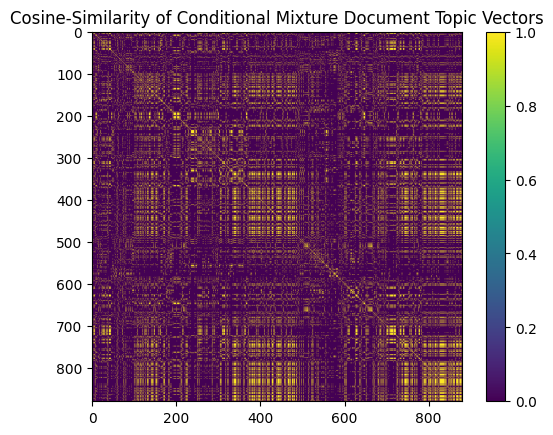

In [208]:
plot_cosine_similarity(conditional_weights, "Conditional Mixture")

One way of assessing the quality of the model's estimated topic vectors is to calculate how many nearest neighbors we must consider before encountering a certain number of documents sharing the same primary article as the search document. For $i = 1, \ldots, n$, let $c_i$ be the specified primary article for document $i$ (our label). For document $i$ we order $\alpha_1, \ldots, \alpha_n$ so that

$$ \langle \alpha_i, \alpha_{i_1} \rangle \leq \cdots \langle \alpha_i, \alpha_{i_n} \rangle $$

and identify $1 \leq i_{n^*} \leq n$ so that, for given count $V$,

$$ V = |\{j \in \{1,\ldots, i_{n^*}\}  : c_i = c_{i_j}\}|. $$

Clearly, the best situation is when $n^* = V$.

 The cummualative probability of these neighborhood sizes provides a fine-grained performance metric.

In [248]:
def plot_model_score(document_weights: np.ndarray, model_str: str) -> None:
    utypes, uidx = np.unique(fvec, return_inverse=True)
    nn_cnt = [0,9,19]
    nbtype = np.zeros((num_documents,len(nn_cnt)), dtype=int)

    for i in range(num_documents):
        
        # X * X[i,:].T
        dd    = np.dot(document_weights, document_weights[i,:])
        dd[i] = -np.inf
        sidx  = np.argsort(-dd)
        
        # Find the ranked locations of the neighbors
        wfreq = np.sort(np.flatnonzero(uidx[sidx]== uidx[i]))

        # Get minimal neighborhood sizes where count equals specified values
        nbtype[i,:] = wfreq[nn_cnt]

    fig, ax = plt.subplots()
    cdf_y = np.arange(1.0,num_documents+1)/num_documents
    cdf_y = np.append(cdf_y, 1.0)

    for i,v in enumerate(nn_cnt):

        sd = np.sort(nbtype[:,i])
        ax.plot(np.append(sd, num_documents), cdf_y, label='Count = %d'%(v+1))
        ax.set_title(f"{model_str}: Neighborhood Search")
        ax.set_ylabel("P(Valid Neighbors)", fontsize=14)
        ax.set_xlabel('Neighborhood Size', fontsize=14)
    ax.legend()
    None

Let's see how this looks for the conditional model.

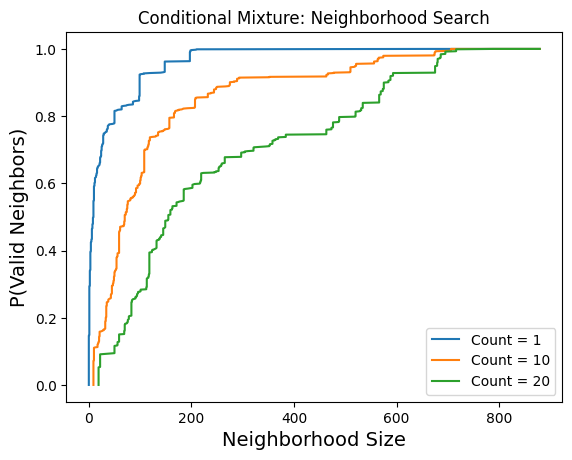

In [249]:
plot_model_score(conditional_weights, "Conditional Mixture")

Not too bad. This took some time to fit and seems to have really over fit some of the document weights. We could play around with the model more and find the right type of regularization here. Instead let's move on to another model that should be faster, but may require a little more work to do inference with. 

### Composite Mixture
Now we are going to try to construct the PLSI model with composite mixture model. Here is what we want for each observation:

$$P((d, \boldsymbol{w})) = P(D=d) \sum_{z} \prod_{i=1}^{n} P(w|Z=z) P(Z=z \vert D=d)$$

We are going to rely on a trick after estimation. To motivate this, observe

$$P(D=d \vert Z=z) P(Z=z) = P(Z=z \vert D=d) P(D=d).$$

This allows us to write the PLSI model as a composite mixture of the form:

$$P((d, \boldsymbol{w})) = \sum_{z} P(d | Z=z) \prod_{i=1}^{n} P(w|Z=z) P(Z=z)$$

Let's think about the estimator. We can re-use the document estimator (`doc_est`) and word estimator (`word_est`) from the `ConditionalDistribution` fit. We simply wrap the two estimators with a `CompositeEstimator` and pass the result to a `MixtureEstimator` wrapper.

In [211]:
est0 = CompositeEstimator([doc_est, word_est])
est = MixtureEstimator([est0] * num_topics)

In [212]:
_, mm_composite = best_of(
    data=wiki_data,
    est=est,
    trials=5,
    init_p=0.10,
    vdata=wiki_data,
    delta=1.0e-6,
    max_its=10,
    print_iter=5,
    init_estimator=est,
    rng=np.random.RandomState(141)
)

Iteration 5. LL=-1681791.847465, delta LL=5.660218e-02
Iteration 10. LL=-1681791.814360, delta LL=1.799648e-04
Trial 1. VLL=-1681791.814360
Iteration 5. LL=-1680673.432397, delta LL=1.276140e+00
Iteration 10. LL=-1680670.478367, delta LL=1.450666e-03
Trial 2. VLL=-1680670.478367
Iteration 5. LL=-1695784.260540, delta LL=1.188905e-01
Iteration 10. LL=-1695781.859426, delta LL=4.079663e-04
Trial 3. VLL=-1695781.859426
Iteration 5. LL=-1684114.440313, delta LL=4.480418e-01
Trial 4. VLL=-1684113.775830
Iteration 5. LL=-1687382.731682, delta LL=1.916215e+00
Iteration 10. LL=-1687381.143787, delta LL=9.334511e-04
Trial 5. VLL=-1687381.143787


In [213]:
composite_fit = optimize(
    data=wiki_data,
    estimator=est,
    prev_estimate=mm_composite,
    delta=1.0e-6,
    max_its=25,
    print_iter=5)

Iteration 3: ln[p_mat(Data|Model)]=-1.680670e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.826579e-07


#### Getting the document weights
Alright, we have fit the model. It was much faster than the conditional mixture model as expected. Now we need to obtain the document level weights. To do this, we can simply pop-off the document components $P(D=d | Z=z)$ and form document level weights via 

$$P(Z=z \vert D) = \frac{P(D=d | Z=z)P(Z=z)}{\sum_{z} P(D=d | Z=z)P(Z=z)} = \frac{P(D=d | Z=z)P(Z=z)}{P(D=d)}$$

This is easily done by poping off $P(Z=z \vert D=d)$ from each mixture component and forming a new `MixtureDistribution` with components $P(D=d \vert Z=z)$ and weights $P(Z=z)$. We can then call `seq_posterior` on a encoded data sequence of all document ids.

In [250]:
def get_composite_document_weights(fit: MixtureDistribution) -> np.ndarray:

    # get the document component P(D=d | Z=z)
    doc_comps = [comp.dists[0] for comp in fit.components]
    # Get the mixture weights P(Z=z)
    w = fit.w
    # Form the mixture \sum_{z} P(D=d | Z=z) P(Z=z)
    doc_mix = MixtureDistribution(components=doc_comps, w=w)
    # encode document ids for a fast posterior calculation
    enc_doc_ids = seq_encode(data=[i for i in range(num_documents)], model=doc_mix)[0][1]
    # Get P(Z=z | D=d) for all document ids
    doc_weights = doc_mix.seq_posterior(enc_doc_ids)

    return doc_weights

This involved a little work, but it is a fairly standard trick to utilize with `dmx-learn` models. 

In [251]:
composite_weights = get_composite_document_weights(composite_fit)

We can make a cosine similarity plot as before. Just keep in mind, although we estimated 10 topic distributions, their enumerations may have changed leading to different posterior representations for each document weight. It still remains true that similarity should be highest near the diagonals.

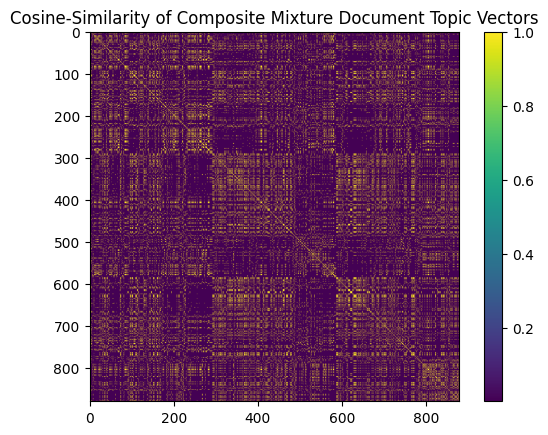

In [252]:
plot_cosine_similarity(composite_weights, "Composite Mixture")

Printing out a document and the associated document weights...

In [253]:
doc = 201

print('Document %d primary Wikipedia article = %s.'%(doc,fvec[doc]))
print('-'*10)
print('Some words:')
print(','.join([wlist[u[0]] for u in wiki_data[doc][1]][:50]))
print('-'*10)
print('PLSA topic probabilties:')
print('\n'.join(map(str,zip(range(num_topics), composite_weights[doc, :].tolist()))))


Document 201 primary Wikipedia article = Food.
----------
Some words:
ingestion,is,the,consumption,of,a,substance,by,an,organism,in,animals,it,normally,accomplished,taking,through,mouth,into,gastrointestinal,tract,such,as,eating,or,drinking,single,celled,organisms,can,take,place,cell,membrane,besides,nutritional,items,other,substances,which,may,be,ingested,include,medication,where,termed,oral,administration,recreational
----------
PLSA topic probabilties:
(0, 0.0011061116266198408)
(1, 0.0011163305611287724)
(2, 0.00111819858394207)
(3, 0.989973054875778)
(4, 0.0011204024765717312)
(5, 0.0011255471918626629)
(6, 0.0010883030194887271)
(7, 0.0011167440220803968)
(8, 0.0011211574142208894)
(9, 0.0011141502283069185)


The weights look smoother. That is they are not just 1.0 and 0.0 elsewhere. Estimation with `ConditionalDistribution`'s can lead to annoying numeric instabilities and is also slow for large document counts.

Let's take a look at the model performance for the composite mixture...

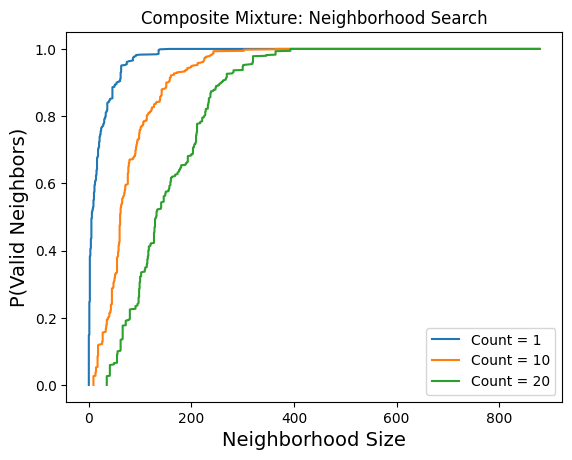

In [254]:
plot_model_score(composite_weights, "Composite Mixture")

The results look a bit better. Again this is likely due to smoothing as the models are essentially the same thing. 

It was a bit more work to obtain the document level weights, but we were able to dramatically speed up the estimation time. Sometimes we will have to choose between simplicity and efficiency. In this case, let's not settle for either and go after both. 

### IntegerPLSIEstimator

The composite mixture offered a speed up in comparison to the conditional mixture model. We also saw there may be some weird numeric issues or smoothing that needs to be handled. It is often the case that when models that can be constructed from `dmx-learn` combinators and base distributions occur frequently enough or require tedious calculations, we think to add these distributions directly into `dmx-learn`. 

In this case, the `IntegerPLSIEstimator` will fit the model we are after directly. It is also optimized under the hood to take advantage of knowing the data format apriori. This generally results in faster fitting, faster inference, and more robust estimation / memory management. 

Let's take a look at how much easier this is by defining the `IntegerPLSIEstimator`. For reference: 

- **num_vals** (int): Number of words in vocabulary.
- **num_states** (int): Number of topics / latent states.
- **num_docs** (int): Number of documents.
- **len_estimator** (Optional[`ParameterEstimator`]): Estimator defined on the non-negative integers for modeling document length.
- **pseudo_count** (tuple[float, float, float]): Regularize the word, topic, and document sufficient statistics.



In [255]:
est = IntegerPLSIEstimator(
    num_vals=num_words, 
    num_states=num_topics, 
    num_docs=num_documents, 
    pseudo_count=(1,1,1)
)

That is it! Now we are ready to find a best fitting model. 

In [256]:
_, mm_plsi = best_of(
    data=wiki_data,
    est=est,
    trials=5,
    init_p=0.10,
    vdata=wiki_data,
    delta=1.0e-6,
    max_its=100,
    print_iter=25,
    init_estimator=est,
    rng=np.random.RandomState(10)
)

Iteration 25. LL=-1678612.268146, delta LL=1.226877e+03
Iteration 50. LL=-1665686.919865, delta LL=3.082480e+02
Iteration 75. LL=-1659813.864553, delta LL=1.658292e+02
Iteration 100. LL=-1656418.975642, delta LL=1.517078e+02
Trial 1. VLL=-1656418.975642
Iteration 25. LL=-1684068.371550, delta LL=1.259625e+03
Iteration 50. LL=-1670802.182141, delta LL=2.829083e+02
Iteration 75. LL=-1665192.809145, delta LL=2.500507e+02
Iteration 100. LL=-1660277.488162, delta LL=2.026224e+02
Trial 2. VLL=-1660277.488162
Iteration 25. LL=-1683789.694056, delta LL=1.499747e+03
Iteration 50. LL=-1666866.919286, delta LL=3.798466e+02
Iteration 75. LL=-1659226.847230, delta LL=2.236454e+02
Iteration 100. LL=-1654838.207090, delta LL=1.365175e+02
Trial 3. VLL=-1654838.207090
Iteration 25. LL=-1680416.303487, delta LL=1.480052e+03
Iteration 50. LL=-1663901.136471, delta LL=3.194903e+02
Iteration 75. LL=-1657540.721119, delta LL=2.281074e+02
Iteration 100. LL=-1653180.485998, delta LL=1.140275e+02
Trial 4. VLL=

We can iterate a bit on the best fitting model.

In [257]:
plsi_model = optimize(
    data=wiki_data,
    estimator=est,
    prev_estimate=mm_plsi,
    delta=1.0e-6,
    max_its=1000,
    print_iter=100)

Iteration 100: ln[p_mat(Data|Model)]=-1.647504e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.015444e+01
Iteration 200: ln[p_mat(Data|Model)]=-1.645363e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.035249e+01
Iteration 300: ln[p_mat(Data|Model)]=-1.644181e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.881837e+00
Iteration 400: ln[p_mat(Data|Model)]=-1.643756e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=6.637390e+00
Iteration 500: ln[p_mat(Data|Model)]=-1.643650e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.067523e-01
Iteration 600: ln[p_mat(Data|Model)]=-1.643631e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.245748e+00
Iteration 700: ln[p_mat(Data|Model)]=-1.643508e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.955588e-01
Iteration 800: ln[p_mat(Data|Model)]=-1.643495e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=9.403534e-03
Iteration 900: ln[p_mat(Data|Model)]=-1.643495e+06, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevMode

Let's examine some of the estimated parameters. For starters, we are most interested in the document level weights $P(Z=z \vert D=d)$. We can easily pop this off as the attribute `state_mat`

In [258]:
plsi_weights = plsi_model.state_mat

The estimate for P(D=d) is stored in `doc_vec` while the estimates for the word probabilities in each topic are stored in `prob_mat`.

In [259]:
print(f"P(D=d) has length = {len(plsi_model.doc_vec)}, which is equal to the number of documents.")

print(f"P(W=w| Z=z) should have shape (num_words, num_topics) = {plsi_model.prob_mat.shape}.")

P(D=d) has length = 879, which is equal to the number of documents.
P(W=w| Z=z) should have shape (num_words, num_topics) = (19545, 10).


Let's take a look at some of the document weights again...

In [260]:
doc = 201

print('Document %d primary Wikipedia article = %s.'%(doc,fvec[doc]))
print('-'*10)
print('Some words:')
print(','.join([wlist[u[0]] for u in wiki_data[doc][1]][:50]))
print('-'*10)
print('PLSA topic probabilties:')
print('\n'.join(map(str,zip(range(num_topics), plsi_weights[doc,:].tolist()))))


Document 201 primary Wikipedia article = Food.
----------
Some words:
ingestion,is,the,consumption,of,a,substance,by,an,organism,in,animals,it,normally,accomplished,taking,through,mouth,into,gastrointestinal,tract,such,as,eating,or,drinking,single,celled,organisms,can,take,place,cell,membrane,besides,nutritional,items,other,substances,which,may,be,ingested,include,medication,where,termed,oral,administration,recreational
----------
PLSA topic probabilties:
(0, 0.0025307384363630297)
(1, 0.0008982578412272345)
(2, 0.0007956323854374228)
(3, 0.004736935952964466)
(4, 0.0010819998023117337)
(5, 0.9842547412912653)
(6, 0.0006765513520150501)
(7, 0.003049819552562685)
(8, 0.0008419620432036375)
(9, 0.0011333613426495258)


We can also plot our cosine similarity map for reference.

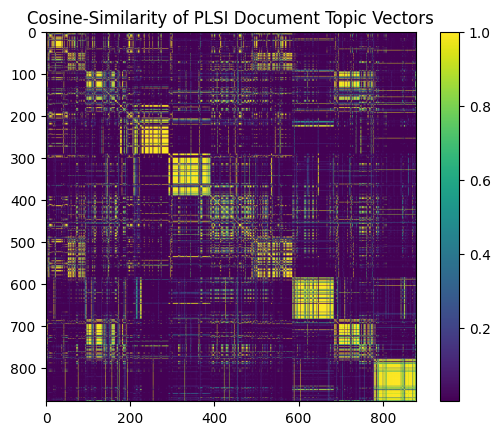

In [261]:
plot_cosine_similarity(plsi_weights, "PLSI")

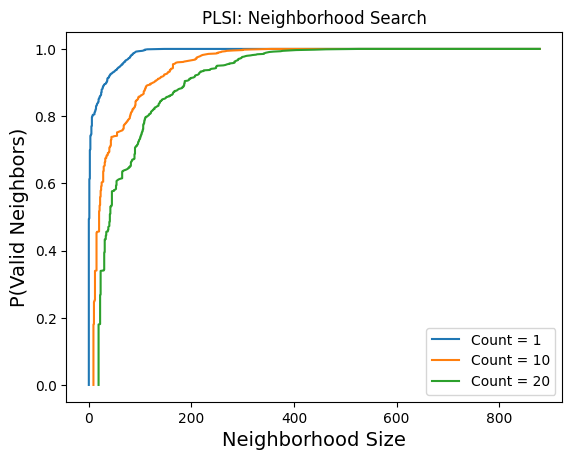

In [262]:
plot_model_score(plsi_weights, "PLSI")

Again we see a slight performance increase in comparison to the composite mixture. This is again likely due to our ability to better handle some of the numeric instabilties you may encounter. We also directly model the document weights which can help with this. 

Overall, you should notice that there are multiple ways to build a similar model in `dmx-learn`. It is sometimes worthwhile to add in a model, such as we saw here, to speed up estimation or to add new features. Keep this in mind, as it is not too hard to add user-defined models to `dmx-learn`. 